# JWST - RGB image

This notebook produces an RGB (false 3-colour) image from James Webb Space Telescope (JWST) observations of the galaxy NGC 4321.

We use the following filters:
* red = `F770W` + `F1000W` + `F1130W` + `F2100W`
* green = `F360M` + `F770W`
* blue = `F300M` + `F335M`

Similarly to the previous notebook (`1_hst_rgb_image.ipynb`), we use Lupton RGB package.

We use JWST observations of the nearby, spiral galaxy NGC 4321 (M100). 
The data is part of the PHANGS-JWST treasury survey and publicly available via: https://archive.stsci.edu/hlsp/phangs/phangs-jwst
Here, we use the drizzled science image, which are the science-ready images.

### Load packages

In [1]:
import numpy as np  # work with data as numpy arrays
from astropy.io import fits  # load FITS files
from astropy.wcs import WCS  # coordinate system from FITS file
import matplotlib.pyplot as plt  # plotting
from astropy.visualization import make_lupton_rgb  # RGB image from 3 images, using arcsinh stretch
from PIL import Image, ImageEnhance  # image manipulation
from reproject import reproject_interp # reproject pixel grid
import warnings
warnings.filterwarnings("ignore")  # mute warnings

### Load data

In [2]:
# directories
data_dir = '../data/'  # data directory, edit as needed
image_dir = '../images/' # directory to save created images, edit as needed

In [3]:
# file names
galaxy = 'ngc4321'
jwst_300_fits = data_dir + 'jwst/' + galaxy + '_nircam_lv3_f300m_i2d_anchor.fits'
jwst_335_fits = data_dir + 'jwst/' + galaxy + '_nircam_lv3_f335m_i2d_anchor.fits'
jwst_360_fits = data_dir + 'jwst/' + galaxy + '_nircam_lv3_f360m_i2d_anchor.fits'
jwst_770_fits = data_dir + 'jwst/' + galaxy + '_miri_lv3_f770w_i2d_anchor.fits'
jwst_1000_fits = data_dir + 'jwst/' + galaxy + '_miri_lv3_f1000w_i2d_anchor.fits'
jwst_1130_fits = data_dir + 'jwst/' + galaxy + '_miri_lv3_f1130w_i2d_anchor.fits'
jwst_2100_fits = data_dir + 'jwst/' + galaxy + '_miri_lv3_f2100w_i2d_anchor.fits'

# load fits files
# these are multiextension files, so we need to unpack the right HDU
hdu_jwst_300 = fits.open(jwst_300_fits)[1]
hdu_jwst_335 = fits.open(jwst_335_fits)[1]
hdu_jwst_360 = fits.open(jwst_360_fits)[1]
hdu_jwst_770 = fits.open(jwst_770_fits)[1]
hdu_jwst_1000 = fits.open(jwst_1000_fits)[1]
hdu_jwst_1130 = fits.open(jwst_1130_fits)[1]
hdu_jwst_2100 = fits.open(jwst_2100_fits)[1]
jwst_300, jwst_300_header = hdu_jwst_300.data, hdu_jwst_300.header
jwst_335, jwst_335_header = hdu_jwst_335.data, hdu_jwst_335.header
jwst_360, jwst_360_header = hdu_jwst_360.data, hdu_jwst_360.header
jwst_770, jwst_770_header = hdu_jwst_770.data, hdu_jwst_770.header
jwst_1000, jwst_1000_header = hdu_jwst_1000.data, hdu_jwst_1000.header
jwst_1130, jwst_1130_header = hdu_jwst_1130.data, hdu_jwst_1130.header
jwst_2100, jwst_2100_header = hdu_jwst_2100.data, hdu_jwst_2100.header

# get coordinate system
wcs_jwst = WCS(jwst_770_header)

The **NIRCAM** and **MIRI** images are not on the same pixel grid, so we need to reproject to a common grid. Here, we choose to reproject onto the MIRI grid.

In [4]:
# reproject NIRCAM maps to MIRI grid
jwst_300, _ = reproject_interp((jwst_300, jwst_300_header), jwst_770_header)
jwst_335, _ = reproject_interp((jwst_335, jwst_335_header), jwst_770_header)
jwst_360, _ = reproject_interp((jwst_360, jwst_360_header), jwst_770_header)

### Create RGB image

In [5]:
# relative scaling of colours
scaling_red = 1
scaling_green = 1
scaling_blue = 1

# define red, green, and blue images
image_r = (40/100*jwst_770/np.nanmax(jwst_770) + 20/100*jwst_1000/np.nanmax(jwst_1000) + 20/100*jwst_1130/np.nanmax(jwst_1130) + 20/100*jwst_2100/np.nanmax(jwst_2100)) * scaling_red
image_g = (75/100*jwst_360/np.nanmax(jwst_360) + 25/100*jwst_770/np.nanmax(jwst_770)) * scaling_green
image_b = (50/100*jwst_300/np.nanmax(jwst_300) + 50/100*jwst_335/np.nanmax(jwst_335)) * scaling_blue

# make 3-color image
jwst_fname = image_dir + galaxy + '_jwst_rgb_image.jpg'
image_jwst = make_lupton_rgb(image_r, image_g, image_b, minimum=0, stretch=0.008, Q=15, filename=jwst_fname)

# edit saturation
image_jwst = Image.open(jwst_fname)
converter = ImageEnhance.Brightness(image_jwst)
image_jwst = converter.enhance(1.5)

# edit sharpness
converter = ImageEnhance.Sharpness(image_jwst)
image_jwst = converter.enhance(3)

# save image to jpg
image_jwst.save(jwst_fname) 

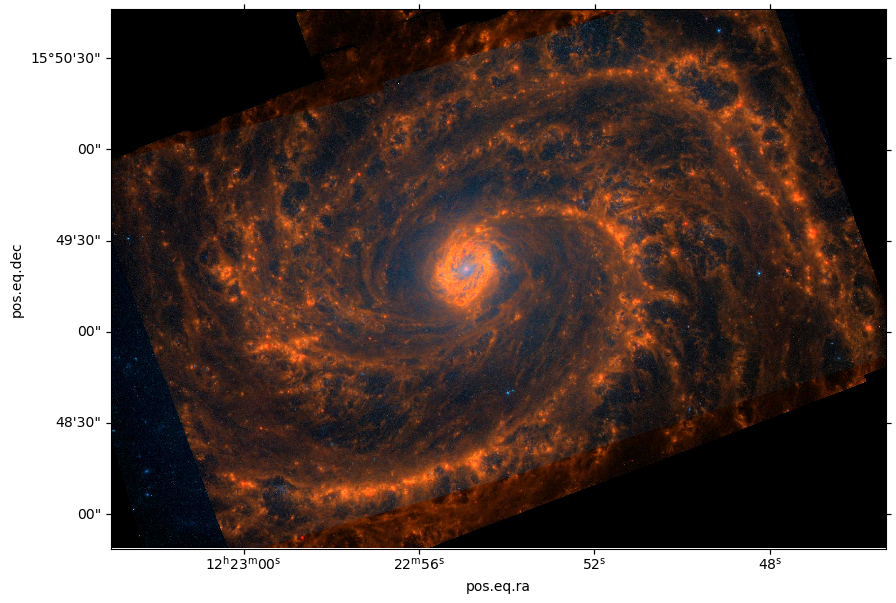

In [6]:
# plotting
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs_jwst)

# plot rgb image
im = ax.imshow(image_jwst, transform=ax.get_transform(wcs_jwst))

plt.xlim(200,2500)
plt.ylim(200,1800)

plt.show()